In [14]:
%pylab inline
#%load_ext line_profiler
import pandas as pd
from chainconsumer import ChainConsumer
import seaborn as sns
rcParams['figure.dpi'] = 160
mpl.rc("pdf", fonttype=42)

def _tfold(t, per, tc):
    return np.mod(((t - tc) + 0.5 * per),per) -  0.5 * per

from matplotlib import ticker

Populating the interactive namespace from numpy and matplotlib


## Use importance sampling to derive posteriors

- Assume we have measured mean stellar density to 12\% fractional precision, which is possible given Gaia parallaxes
- Apply various priors on eccentricity
  - Uniform $\mathcal{U}(0,0.99)$
  - Van Eylen+19 distribution for singles $\mathcal{N}^{+}(0,0.3)$
  - Van Eylen+19 distribution for multis $\mathcal{N}^{+}(0,0.08)$
 
- I have not yet implemented a transit prior, which depends on a/Rstar and ecc
- I have not yet implemented a minimum periastron prior

In [15]:
logrho_obs = (0.0,0.05)
def importance_sampling(chain, logrho_obs, fupsample=10, eccprior='uniform'):
    """
    Compute weights (importance sampling) based on difference measured rhostar and eccentricity priors
    """

    rho = chain["rho"]
    logrho_circ = np.log10(rho)
    logrho_circ = np.hstack([logrho_circ ]*fupsample)
    r = np.hstack([chain["r"]]*fupsample)
    b = np.hstack([chain["b"]]*fupsample)

    if eccprior=='uniform':
        ecc = np.random.uniform(0, 0.99, len(logrho_circ))
    elif eccprior=='v19-single':
        ecc = abs((randn(len(logrho_circ)) * 0.3 ))
        eccmax = np.ones_like(ecc) * 0.99
        ecc = np.min(vstack([ecc,eccmax]),axis=0)
    elif eccprior=='v19-multi':
        ecc = abs((randn(len(logrho_circ)) * 0.08 ))
        eccmax = np.ones_like(ecc) * 0.99
        ecc = np.min(vstack([ecc,eccmax]),axis=0)
    elif eccprior=='zero':
        ecc = abs((randn(len(logrho_circ)) * 0.00001 ))
        eccmax = np.ones_like(ecc) * 0.99
        ecc = np.min(vstack([ecc,eccmax]),axis=0)
    else:
        assert False, "prior not implemented"

    omega = np.random.uniform(-0.5*np.pi, 1.5*np.pi, len(logrho_circ))
    omega_deg = np.rad2deg(omega)
    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    logrho = logrho_circ - log10(g**3) 
    log_weight = -0.5 * ((logrho - logrho_obs[0]) / logrho_obs[1]) ** 2
    weight = np.exp(log_weight - np.max(log_weight))
    chain2 = pd.DataFrame(dict(r=r,b=b,ecc=ecc,logrho_circ=logrho_circ,omega=omega,omega_deg=omega_deg, weight=weight))
    chain2 = chain2.sort_values(by='weight')
    chain2 = chain[(chain2.weight.cumsum() / chain2.weight.sum()) > 1e-3]
    return chain2

def add_eccpriors(chain):
    chain2 = []
    _chain = chain.copy()
    _chain['eccprior'] = 'none'
    chain2.append(_chain)

    eccprior = 'uniform'
    _chain = importance_sampling(chain, logrho_obs, fupsample=10,eccprior=eccprior)
    _chain['eccprior'] = eccprior
    chain2.append(_chain)
    
    eccprior = 'v19-single'
    _chain = importance_sampling(chain, logrho_obs, fupsample=10,eccprior=eccprior)
    _chain['eccprior'] = eccprior
    chain2.append(_chain)
    
    eccprior = 'v19-multi'
    _chain = importance_sampling(chain, logrho_obs, fupsample=10,eccprior=eccprior)
    _chain['eccprior'] = eccprior
    chain2.append(_chain)
    
    return pd.concat(chain2)

/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_laun

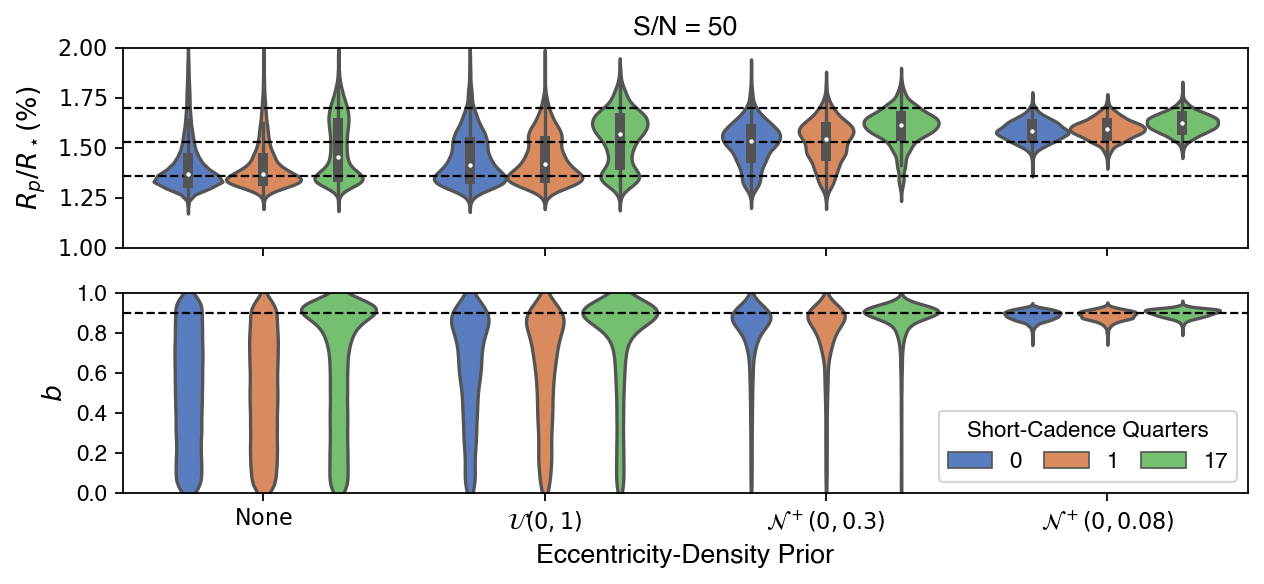

In [16]:
b=0.9
r=0.017
truth = dict(per=11.512312, tc=5.124124,b=b, r=r, ecc=0.0, omega=90)
truth2 = {r'$R_p/R_\star$':r,'$b$':b}

suffix = 'basis=rho_snr=48_ar-99'
dflc = pd.read_csv('chains/chain_lc-{}.csv'.format(suffix),index_col=0)
dflc['sampling'] = '0'
dflc = add_eccpriors(dflc)

dfsc90 = pd.read_csv('chains/chain_sc90-{}.csv'.format(suffix),index_col=0)
dfsc90['sampling'] = '1'
dfsc90 = add_eccpriors(dfsc90)

dfsc = pd.read_csv('chains/chain_sc-{}.csv'.format(suffix),index_col=0)
dfsc['sampling'] = '17'
dfsc = add_eccpriors(dfsc)
df = pd.concat([dflc,dfsc90,dfsc])

fig,axL = subplots(figsize=(8,3.75),nrows=2,sharex=True)

sca(axL[0])
title('S/N = 50')
sns.violinplot(x="eccprior", y="r", data=df,hue="sampling",palette="muted")
ylabel('$R_p / R_\star (\%)$')
for fac in [1,0.9,0.8]:
    axhline(truth['r']*fac,ls='--',lw=1)
ylim(0.010,0.02)
xlabel('')
axL[0].legend().set_visible(False)
ticks = ticker.FuncFormatter(lambda x, pos: '${0:.2f}$'.format(x*100))
axL[0].yaxis.set_major_formatter(ticks)

sca(axL[1])
sns.violinplot(x="eccprior", y="b", data=df,hue="sampling",palette="muted",inner=None)

axhline(truth['b'],ls='--',lw=1)
ylabel('$b$')
xlabel('Eccentricity-Density Prior')
xt = [0,1,2,3]
xtl = [
    r'$\mathrm{None}$',
    r'$\mathcal{U}(0,1)$',
    r'$\mathcal{N}^+(0,0.3)$',
    r'$\mathcal{N}^+(0,0.08)$',
]
xticks(xt,xtl)
yt = [0.0,0.2,0.4,0.6,0.8,1.0]
yticks(yt,yt)
ylim(0,1)
leg = axL[1].legend(loc='lower right',ncol=3,title='Short-Cadence Quarters',fontsize='medium',title_fontsize='medium',handlelength=2, labelspacing=0.5,columnspacing=1)
#leg.set_title(')
tight_layout()
fig.savefig('../paper/fig_violin-snr-50.pdf')

/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_laun

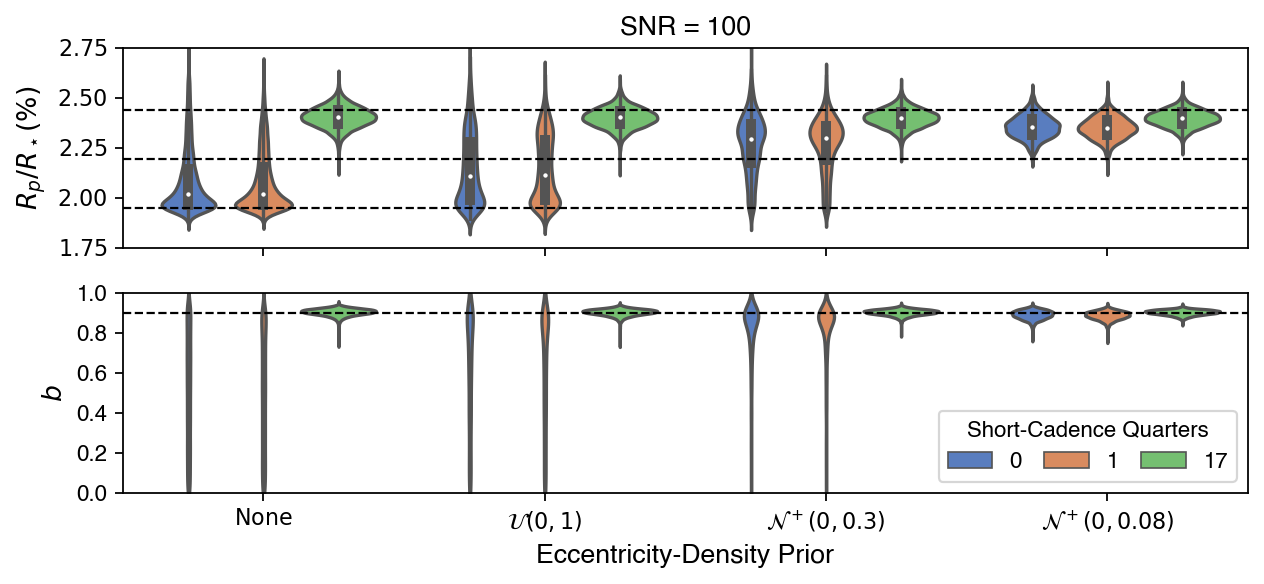

In [17]:
b=0.9
r=0.0244
truth = dict(per=11.512312, tc=5.124124,b=b, r=r, ecc=0.0, omega=90)
truth2 = {r'$R_p/R_\star$':r,'$b$':b}

suffix = 'basis=rho_snr=100_ar-99'


dflc = pd.read_csv('chains/chain_lc-{}.csv'.format(suffix),index_col=0)
dflc['sc'] = '0'
dflc = add_eccpriors(dflc)

dfsc90 = pd.read_csv('chains/chain_sc90-{}.csv'.format(suffix),index_col=0)
dfsc90['sc'] = '1'
dfsc90 = add_eccpriors(dfsc90)

dfsc = pd.read_csv('chains/chain_sc-{}.csv'.format(suffix),index_col=0)
dfsc['sc'] = '17'
dfsc = add_eccpriors(dfsc)
df = pd.concat([dflc,dfsc90,dfsc])


fig,axL = subplots(figsize=(8,3.75),nrows=2,sharex=True)
sca(axL[0])
title('SNR = 100')
sns.violinplot(x="eccprior", y="r", data=df,hue="sc",palette="muted")
axL[0].legend().set_visible(False)
ylabel('$R_p / R_\star (\%)$')
for fac in [1,0.9,0.8]:
    axhline(truth['r']*fac,ls='--',lw=1)

ylim(0.0175,0.0275)
xlabel('')
ticks = ticker.FuncFormatter(lambda x, pos: '${0:.2f}$'.format(x*100))
axL[0].yaxis.set_major_formatter(ticks)


sca(axL[1])
sns.violinplot(x="eccprior", y="b", data=df,hue="sc",palette="muted",inner=None)
axhline(truth['b'],ls='--',lw=1)
ylabel('$b$')
xlabel('Eccentricity-Density Prior')
xt = [0,1,2,3]
xtl = [
    r'$\mathrm{None}$',
    r'$\mathcal{U}(0,1)$',
    r'$\mathcal{N}^+(0,0.3)$',
    r'$\mathcal{N}^+(0,0.08)$',
]
xticks(xt,xtl)
ylim(0,1)
leg = axL[1].legend(loc='lower right',ncol=3,title='Short-Cadence Quarters',fontsize='medium',title_fontsize='medium',handlelength=2, labelspacing=0.5,columnspacing=1)
yt = [0.0,0.2,0.4,0.6,0.8,1.0]
yticks(yt,yt)
ylim(0,1)
tight_layout()
fig.savefig('../paper/fig_violin-snr-100.pdf')